In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings

from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

import os

import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

In [4]:
#import 
df = pd.read_excel('consum_gaze.xls')
print(df)
print(len(df))

      perioada  consum
0   2014-01-01    1392
1   2014-02-01    1301
2   2014-03-01    1064
3   2014-04-01     954
4   2014-05-01     777
..         ...     ...
106 2022-11-01     965
107 2022-12-01    1309
108 2023-01-01    1295
109 2023-02-01    1300
110 2023-03-01    1004

[111 rows x 2 columns]
111


In [6]:
df.columns

Index(['consum'], dtype='object')

In [5]:
#set index data
df=df.set_index('perioada')

In [7]:
df.columns
df

,consum
perioada,
2014-01-01,1392
2014-02-01,1301
2014-03-01,1064
2014-04-01,954
2014-05-01,777
...,...
2022-11-01,965
2022-12-01,1309
2023-01-01,1295


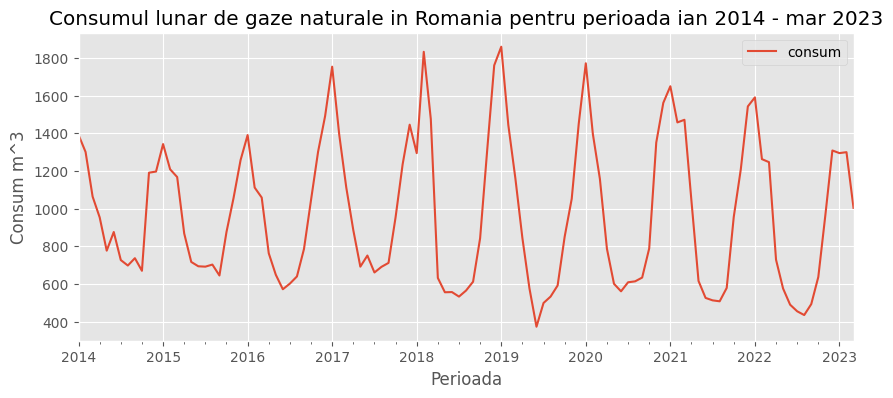

In [9]:
#plot consum lunar
df.plot(figsize=(10, 4),label = 'Consum')
plt.xlabel("Perioada")
plt.ylabel('Consum m^3')
plt.title("Consumul lunar de gaze naturale in Romania pentru perioada ian 2014 - mar 2023")
plt.legend()
plt.show()

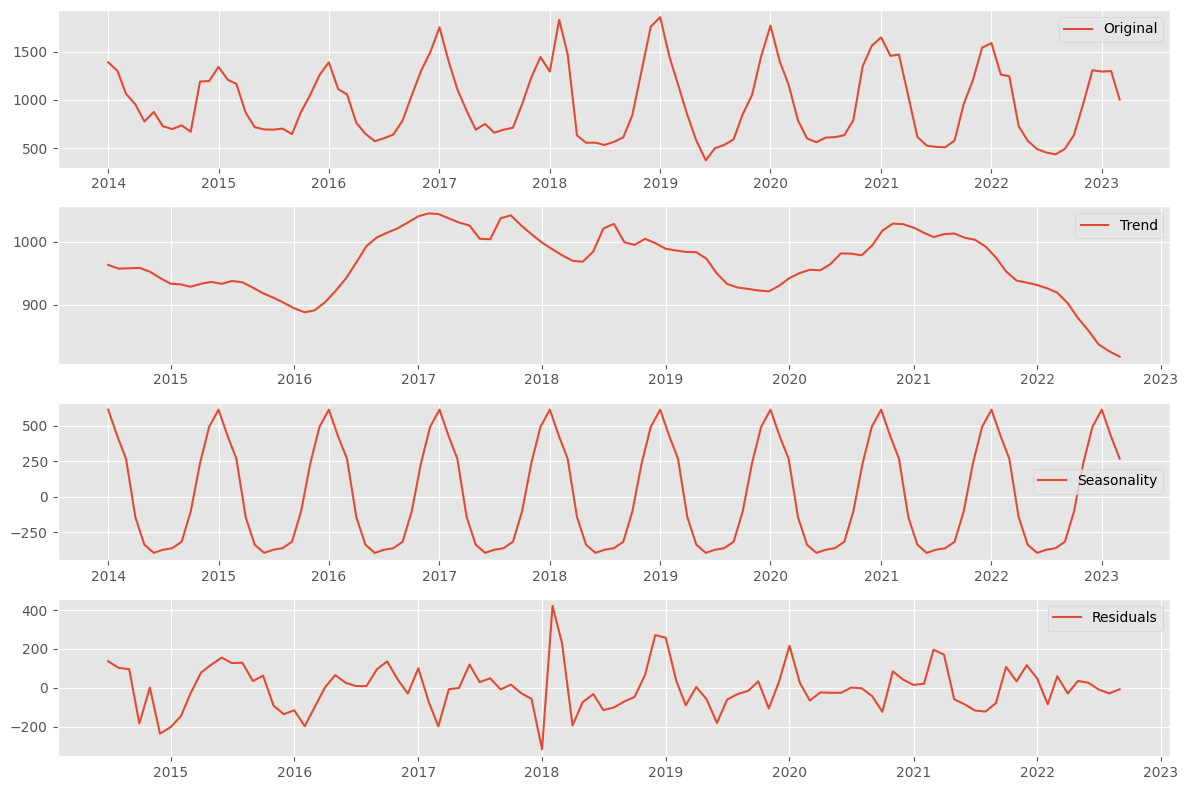

In [10]:
#se observa ca seria prezinta sezonalitate
#descompunere sezoniera

decomposition = seasonal_decompose(df,period=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [11]:
#testare stationaritate serie 
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])
    

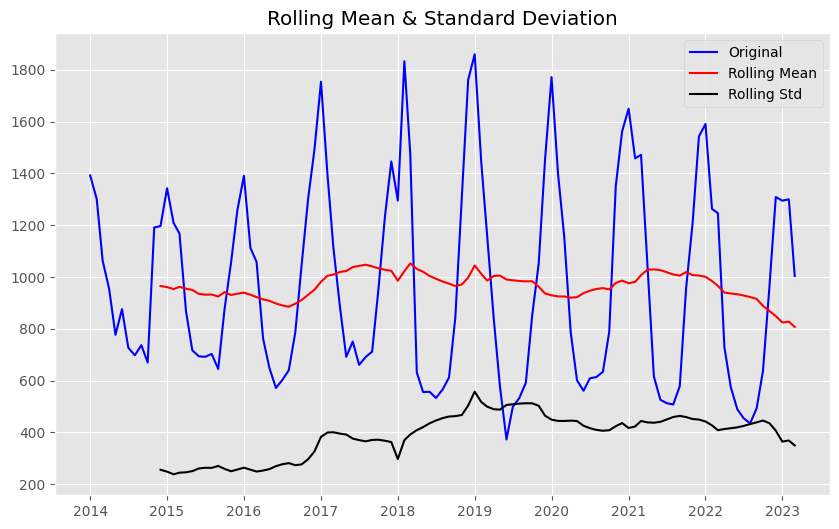

Results of Dickey-Fuller Test:
p-value= 0.9059727852450796


In [12]:
test_stationarity(df)
#cum p-value 0.9>0.1 se accepta ipoteza nula cum ca seria nu este stationara

In [13]:
#diferentiem seria si testam din nou stationaritatea

df_dif = df.diff()
print(df_dif)

            consum
perioada          
2014-01-01     NaN
2014-02-01   -91.0
2014-03-01  -237.0
2014-04-01  -110.0
2014-05-01  -177.0
...            ...
2022-11-01   328.0
2022-12-01   344.0
2023-01-01   -14.0
2023-02-01     5.0
2023-03-01  -296.0

[111 rows x 1 columns]


In [14]:
#se observa o valoare NaN pentru prima perioada,respectiv ian 2014 
#vom elimina valorile NaN din serie pentru a testa stationaritatea seriei diferentiate 
df_dif = df_dif.dropna()
df_dif

,consum
perioada,
2014-02-01,-91.0
2014-03-01,-237.0
2014-04-01,-110.0
2014-05-01,-177.0
2014-06-01,99.0
...,...
2022-11-01,328.0
2022-12-01,344.0
2023-01-01,-14.0


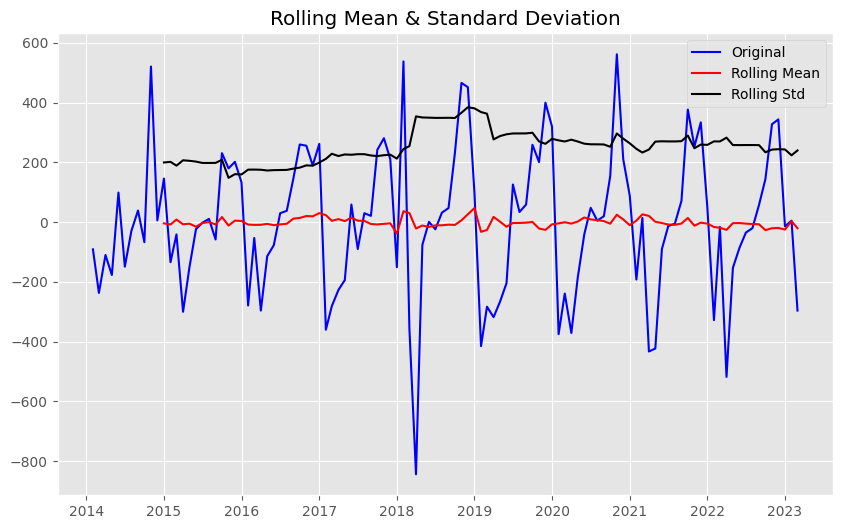

Results of Dickey-Fuller Test:
p-value= 0.014867893498093816


In [15]:
test_stationarity(df_dif)
#cum p-value 0.014 <0.1 se refuza ipoteza nula =>noua serie diferentiata este stationara 
#in continuae vom lucra pe seria stationara

In [68]:
#split in seturi de testare si antrenare
#target:previziune 15 valori (anul 2022 + 3 luni din 2023) - aprox. 14%
#set de antrenare - 86% din serie 95
#set de testare - 14% din serie 15
X=df
train_size = int(len(X) * 0.87)
trainset, testset= X[0:train_size], X[train_size:]

In [69]:
trainset #96 valori aprox 87% din seria diferentiata

,consum
perioada,
2014-01-01,1392
2014-02-01,1301
2014-03-01,1064
2014-04-01,954
2014-05-01,777
...,...
2021-08-01,508
2021-09-01,579
2021-10-01,956


In [66]:
testset #cele 15 valori de la 1 ian 2022 la mar 2023

,consum
perioada,
2022-02-01,1263
2022-03-01,1247
2022-04-01,729
2022-05-01,576
2022-06-01,490
2022-07-01,455
2022-08-01,435
2022-09-01,493
2022-10-01,637


In [91]:
#cum noua serie contine 110 valori,cu 1 mai putin decat seria originala,vom incerca impartirea ei
Y=df_dif
trainD_size = int(len(Y) * 0.87)
trainDset, testDset= Y[0:trainD_size], Y[trainD_size:]

In [92]:
trainDset #95 valori 

,consum
perioada,
2014-02-01,-91.0
2014-03-01,-237.0
2014-04-01,-110.0
2014-05-01,-177.0
2014-06-01,99.0
...,...
2021-08-01,-5.0
2021-09-01,71.0
2021-10-01,377.0


In [19]:
#acuratetea predictiei 

def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

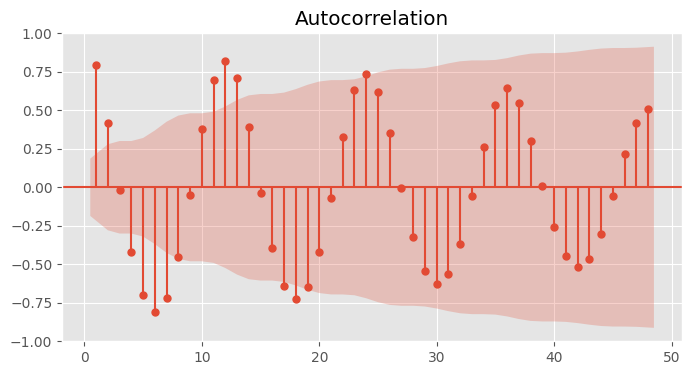

In [70]:
#1. Model SARIMA -Seasonal ARIMA

#ACF 
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=48)
plt.show()

#conform ACF lagul maximal optim ar fi 18 // ultimul lag efectiv in afara intervalului 
#cum datele se repeta la 12 luni - lagul maximal admis ar fi 2
#se observa sezonalitatea seriei cu frecventa o data la 7-8 luni 


In [74]:
#cautare lag optim prin auto_arima 
#m=12 date lunare
#d=1 serie diferentiata
#D=1 diferenta sezoniera
#max_p=2 #lag maximal
import pmdarima as pm
model_12 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

#summary model optim
print(model_12.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1114.537, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1094.366, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1084.018, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1112.623, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1109.363, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1085.763, Time=0.23 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1085.703, Time=0.63 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1092.083, Time=0.23 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1087.502, Time=1.22 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1094.259, Time=0.17 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1086.010, Time=0.46 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1086.013, Time=0.46 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1084.998, Time=0.26 sec
 ARIMA(1,0,2)(0,1,1)[12]

In [75]:
#fitting model
sarima_model_12 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_12 = sarima_model_12.fit()
print(sarima_fit_12.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4927      0.100      4.905      0.000       0.296       0.690
ma.S.L12      -0.7118      0.189     -3.764      0.000      -1.082      -0.341
sigma2      2.096e+04   2567.089      8.167      0.000    1.59e+04     2.6e+04


C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


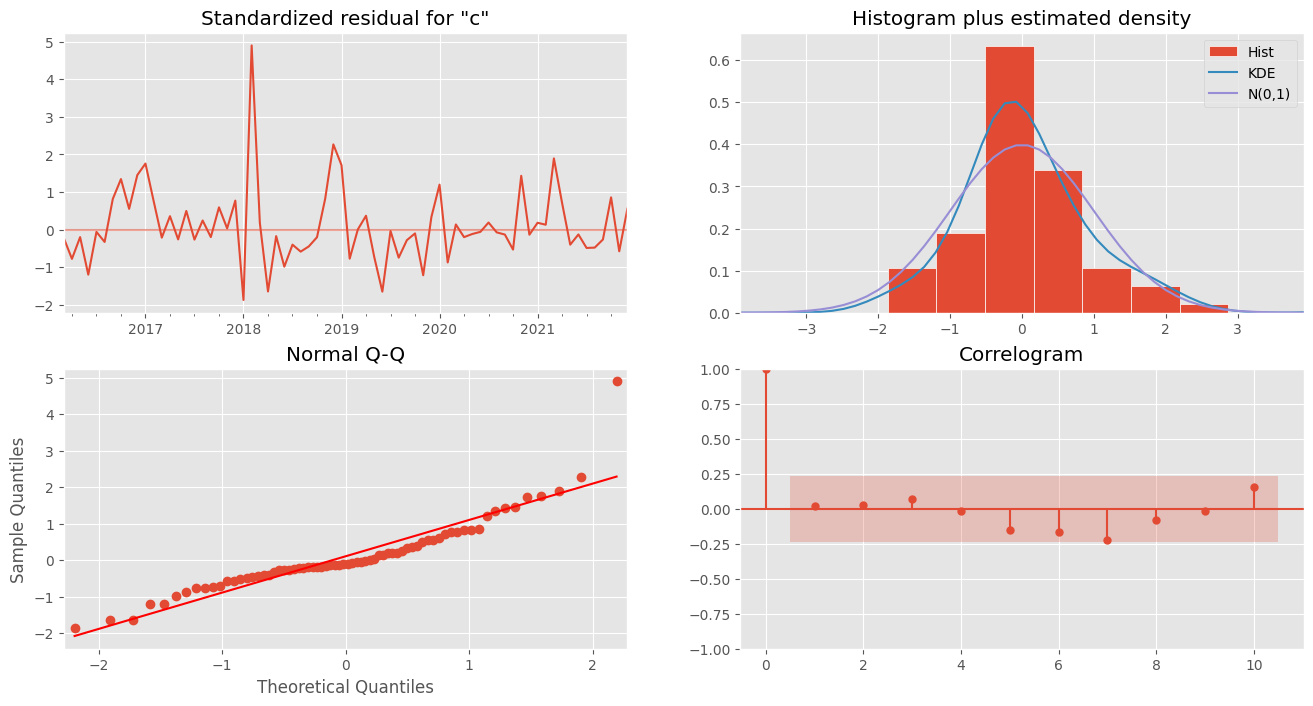

In [76]:
#grafic
sarima_fit_12.plot_diagnostics(figsize=(16, 8))
plt.show()

#conform graficelor ipotezele pe reziduuri sunt respectate
#reziduurile par a urmari o evolutie homocedastica si o distributie normala
#mai mult,conform corelogramei nu exista autocorelare in serie
#modelul ales este unul valid

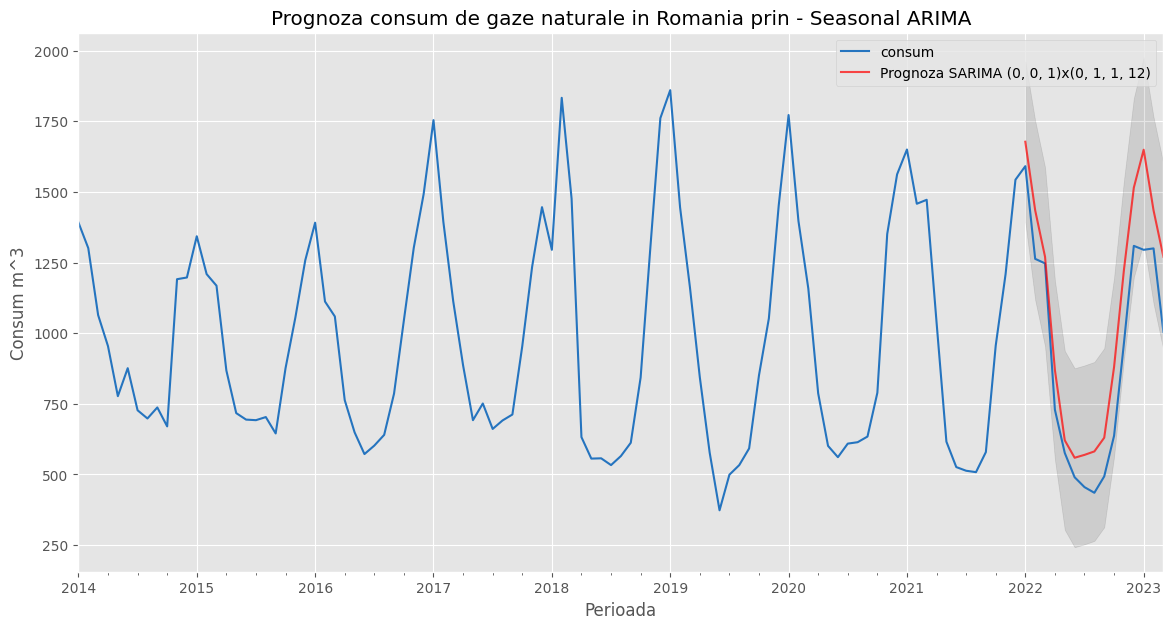

In [77]:
# One step ahead forecast
sarima_predict_12 = sarima_fit_12.get_prediction(start=pd.to_datetime('2022-01-01'), end=pd.to_datetime('2023-03-01')
                                           ,dynamic=False)
sarima_predict_conf_12 = sarima_predict_12.conf_int()
#observed plot
ax = df.plot(label='Initial',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_12.predicted_mean.plot(ax=ax, label='Prognoza SARIMA (0, 0, 1)x(0, 1, 1, 12)', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_12.index,
                #lower sales
                sarima_predict_conf_12.iloc[:, 0],
                #upper sales
                sarima_predict_conf_12.iloc[:, 1], color='k', alpha=0.1)
plt.title('Prognoza consum de gaze naturale in Romania prin - Seasonal ARIMA')
plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend()
plt.show()


In [78]:
#acuratete predictie 
sarima_results2=performance(df["consum"],sarima_predict_12.predicted_mean)
sarima_results2

{'MSE': 33392.37, 'RMSE': 182.74, 'MAPE': 19.58}

In [95]:
#cautare lag optim prin auto_arima 
#m=12 date lunare
#d=1 serie diferentiata
#D=1 diferenta sezoniera
#max_p=2 #lag maximal
import pmdarima as pm
model_11 = pm.auto_arima(trainDset,seasonal=True, m=12,d=1, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

#summary model optim
print(model_11.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1199.831, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1159.651, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1180.931, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1141.239, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1166.839, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1121.035, Time=0.43 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1129.798, Time=0.14 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0

In [ ]:
#modelul optim identificat SARIMAX(2, 1, 0)x(2, 1, 0, 12) 

In [96]:
#fitting model
sarima_model_11 = sm.tsa.statespace.SARIMAX(trainDset,
                                order=(2, 1, 0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_11 = sarima_model_11.fit()
print(sarima_fit_11.summary().tables[1])

C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7493      0.130     -5.778      0.000      -1.003      -0.495
ar.L2         -0.5110      0.152     -3.363      0.001      -0.809      -0.213
ar.S.L12      -0.8097      0.108     -7.488      0.000      -1.022      -0.598
ar.S.L24      -0.4067      0.128     -3.168      0.002      -0.658      -0.155
sigma2      4.996e+04   7982.034      6.259      0.000    3.43e+04    6.56e+04


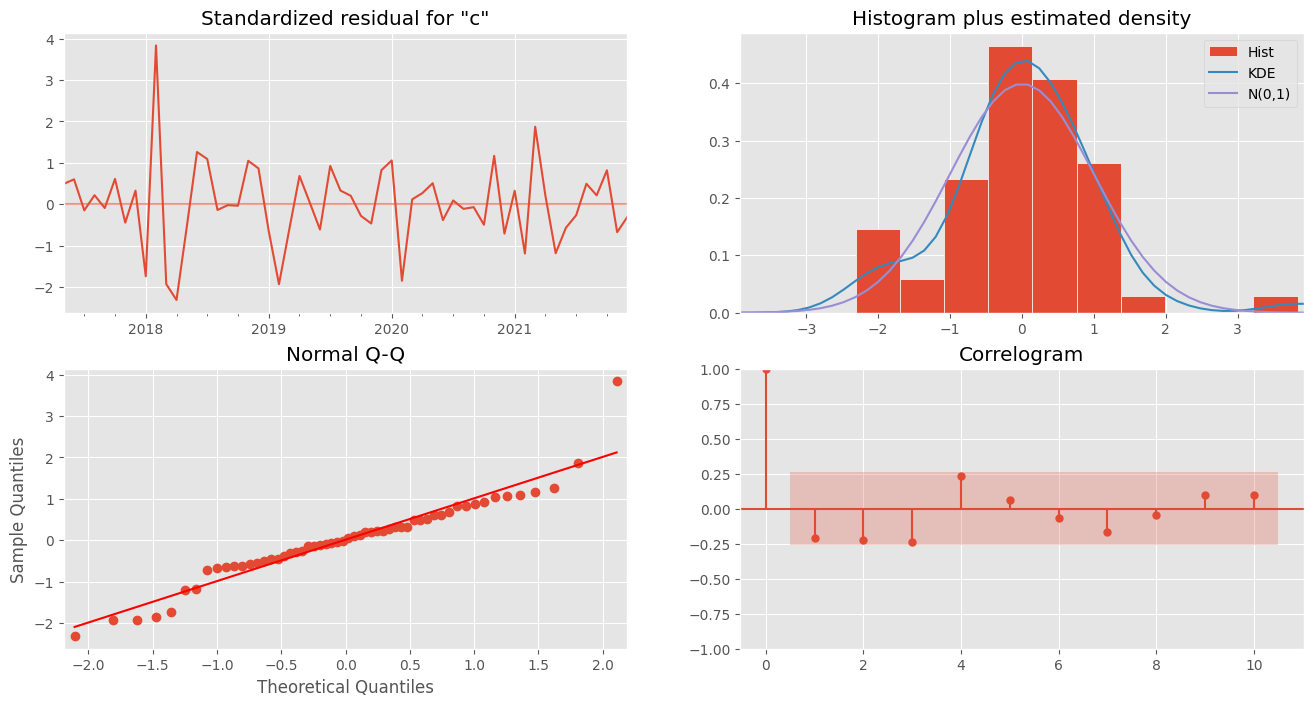

In [97]:
#grafic
sarima_fit_11.plot_diagnostics(figsize=(16, 8))
plt.show()

#conform graficelor ipotezele pe reziduuri sunt respectate
#reziduurile par a urmari o evolutie homocedastica si o distributie normala
#mai mult,conform corelogramei nu exista autocorelare in serie
#modelul ales este unul valid

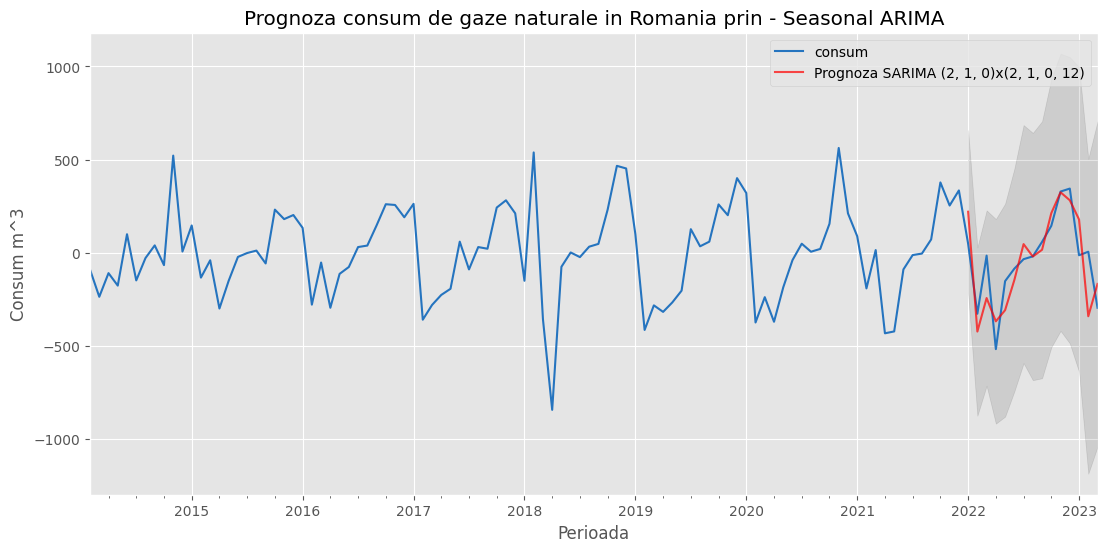

In [98]:
# One step ahead forecast
sarima_predict_11 = sarima_fit_11.get_prediction(start=pd.to_datetime('2022-01-01'), end=pd.to_datetime('2023-03-01')
                                           ,dynamic=False)
sarima_predict_conf_11 = sarima_predict_11.conf_int()
#observed plot
ax = df_dif.plot(label='Initial',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7

sarima_predict_11.predicted_mean.plot(ax=ax, label='Prognoza SARIMA (2, 1, 0)x(2, 1, 0, 12)', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_11.index,
                #lower sales
                sarima_predict_conf_11.iloc[:, 0],
                #upper sales
                sarima_predict_conf_11.iloc[:, 1], color='k', alpha=0.1)
plt.title('Prognoza consum de gaze naturale in Romania prin - Seasonal ARIMA')
plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend()
plt.show()


In [99]:
#acuratete predictie 
sarima_results1=performance(df_dif["consum"],sarima_predict_11.predicted_mean)
sarima_results1

{'MSE': 22072.67, 'RMSE': 148.57, 'MAPE': 715.59}

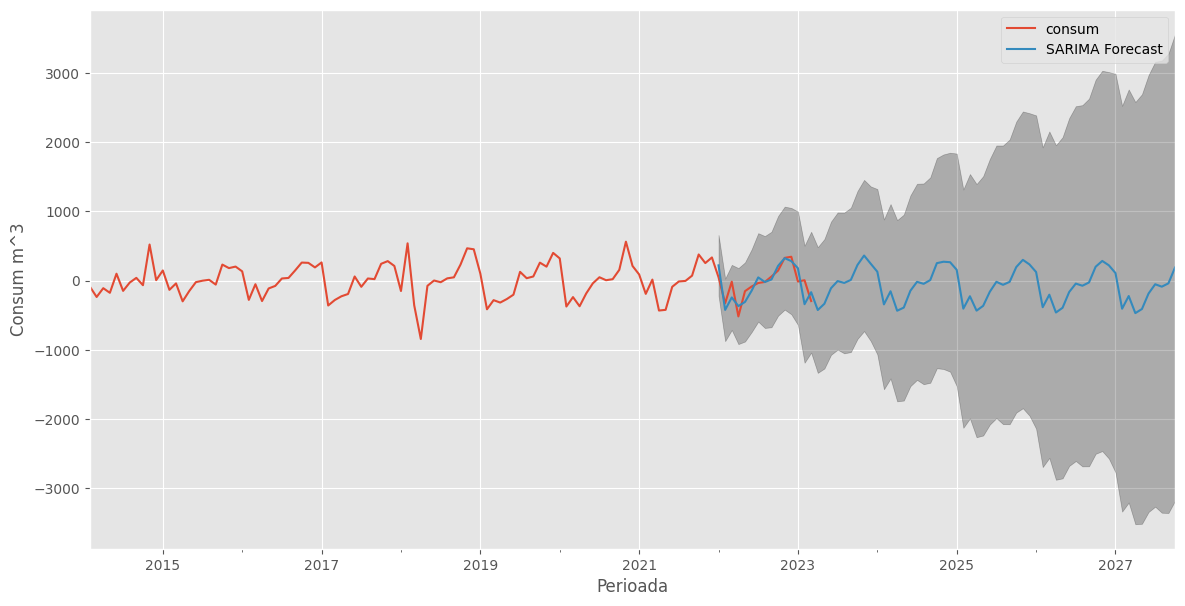

In [100]:
#prognoza perioadele urmatoare
furthur_predict_1 = sarima_fit_11.get_forecast(steps=70)
furthur_conf_1 = furthur_predict_1.conf_int()
ax = df_dif.plot(label='observed', figsize=(14, 7))
furthur_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Forecast')
ax.fill_between(furthur_conf_1.index,
                furthur_conf_1.iloc[:, 0],
                furthur_conf_1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Perioada')
ax.set_ylabel('Consum m^3')
plt.legend()
plt.show()

In [34]:
#2.LSTM Method
#Long Short-Term Memory method

#set testare si antrenare 
train, test = np.array(df[:-15]), np.array(df[-15:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [35]:
#scalarea datelor

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [36]:
n_input = 15
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [37]:
#1.model bidirectional LSTM

# define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(15, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [38]:
model_bi.fit_generator(generator,epochs=100)

C:\Users\user\AppData\Local\Temp\ipykernel_4088\2076291188.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_bi.fit_generator(generator,epochs=100)


Epoch 1/100
9/9 [==============================] - 2s 7ms/step - loss: 0.1839
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.1065
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0644
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0718
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0631
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0587
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0595
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0563
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0557
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0543
Epoch 11/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0491
Epoch 12/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0460
Epoch 13/100
9/9 [==============================] - 0s 7ms/st

In [39]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df_dif[-n_input:].index, columns=['Prediction'])
df_predict_bi

1/1 [==============================] - 0s 20ms/step


,Prediction
perioada,
2022-01-01,1748.912860
2022-02-01,1646.103516
2022-03-01,1314.305945
2022-04-01,965.474834
2022-05-01,705.816685
2022-06-01,541.154473
2022-07-01,466.462590
2022-08-01,494.257585
2022-09-01,618.744304


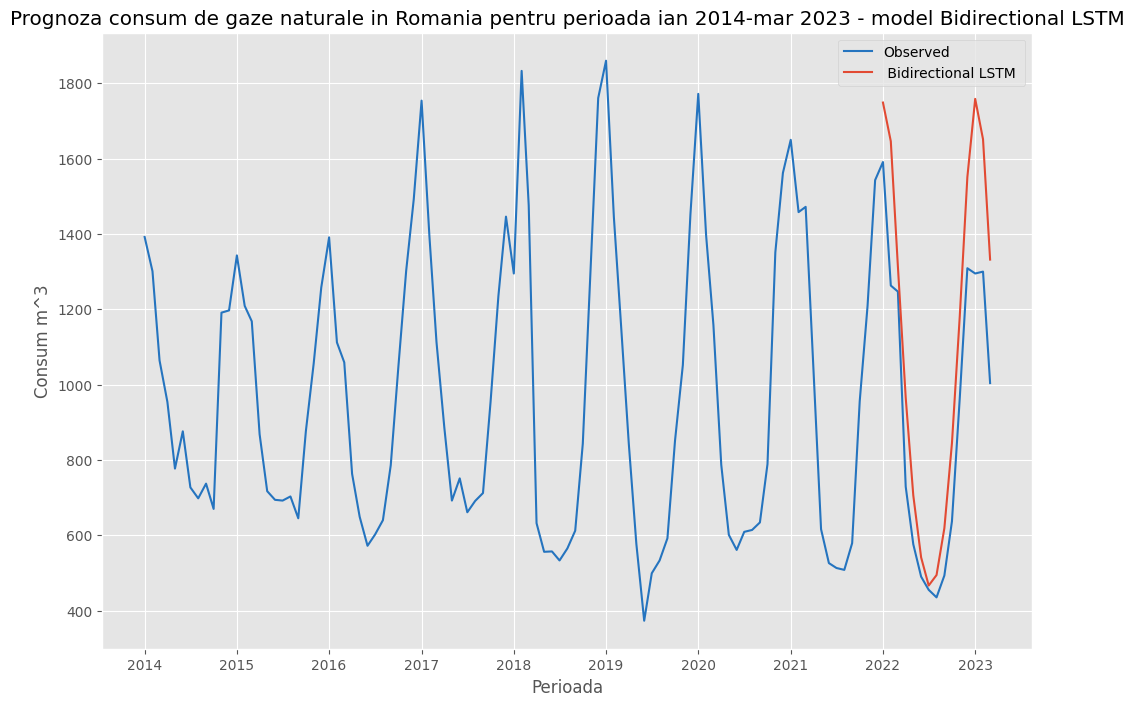

In [40]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[96:].index,df_predict_bi,label=" Bidirectional LSTM ")
plt.title('Prognoza consum de gaze naturale in Romania pentru perioada ian 2014-mar 2023 - model Bidirectional LSTM')
plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend()
plt.show()

In [41]:
bi_lstm= performance(df[-15:]['consum'],df_predict_bi['Prediction'])
bi_lstm_predict=df_predict_bi['Prediction']
bi_lstm

{'MSE': 57726.51, 'RMSE': 240.26, 'MAPE': 21.45}

In [42]:
#3. CNN -Convolutional Neural Network 
dfcnn= np.array(df)
dfcnn= dfcnn.reshape(-1,1)
#Scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [43]:
#Set the timestep
timestep = 12
X= []
Y=[]
raw_data=ts
for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)
#Set the trainset
X_train = X[:84,:,:]  
Y_train = Y[:84] 
#Set the testset
X_test = X[84:,:,:]  
Y_test= Y[84:]

In [59]:
#define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse',metrics='mae')


# fit model
model_nn=cnn_model.fit(X_train, Y_train, epochs=200, verbose=1) 

Epoch 1/200
3/3 [==============================] - 1s 4ms/step - loss: 1107887.6250 - mae: 976.7347
Epoch 2/200
3/3 [==============================] - 0s 6ms/step - loss: 1107486.2500 - mae: 976.5167
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 1106649.0000 - mae: 976.0776
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 1104938.6250 - mae: 975.1719
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 1101588.0000 - mae: 973.3668
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 1095470.1250 - mae: 970.0807
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 1084811.0000 - mae: 964.2491
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 1066846.8750 - mae: 954.5041
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 1037888.7500 - mae: 938.6479
Epoch 10/200
3/3 [==============================] - 0s 5ms/step - loss: 992665.8750 - mae: 913.2298


In [55]:
model_nn.params

{'verbose': 1, 'epochs': 200, 'steps': 3}

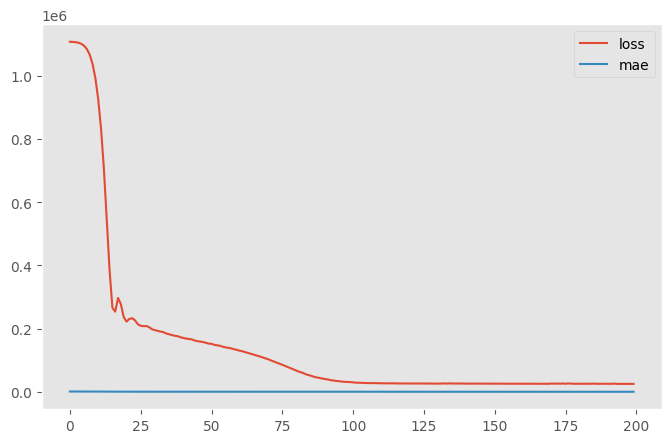

In [61]:
pd.DataFrame(model_nn.history).plot(figsize=(8, 5))
plt.grid()

In [45]:
# Validate data
preds = cnn_model.predict(X_test)
preds=np.array(preds)
preds=preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)


Y_test=np.asanyarray(Y_test)  
Y_test=Y_test.reshape(-1,1) 
Y_test = scaler.inverse_transform(Y_test)


Y_train=np.asanyarray(Y_train)  
Y_train=Y_train.reshape(-1,1) 
Y_train = scaler.inverse_transform(Y_train)


1/1 [==============================] - 0s 96ms/step


In [46]:
cnn= performance(Y_test,preds)
cnn_predict= preds.reshape((15,))
cnn

{'MSE': 55033.15, 'RMSE': 234.59, 'MAPE': 22.95}

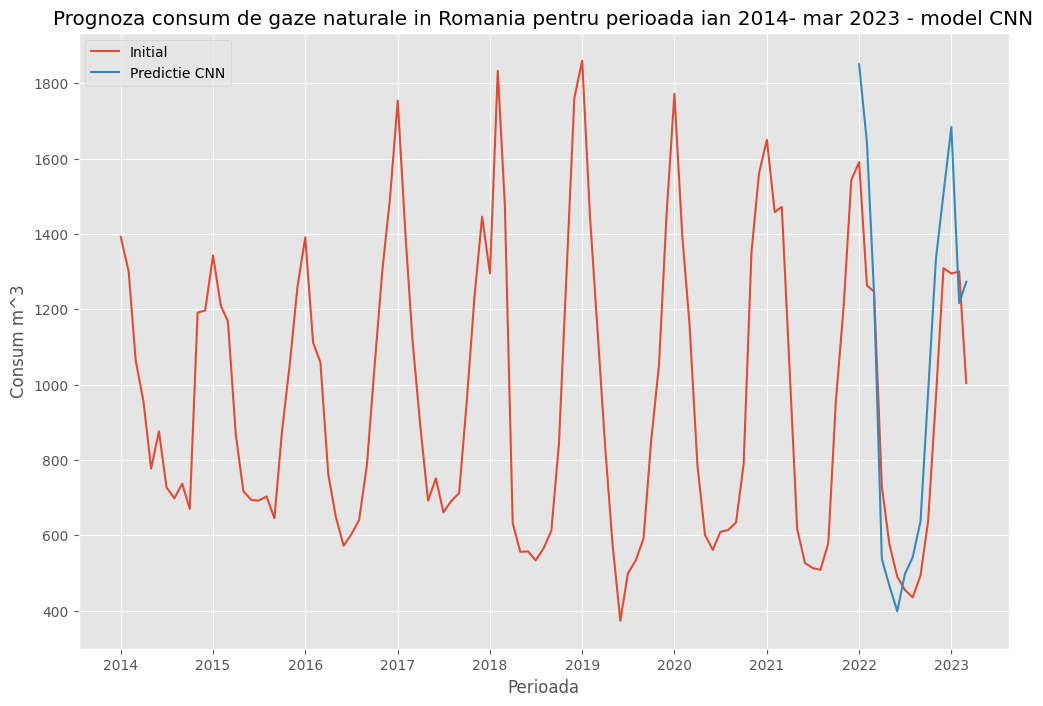

In [47]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Initial")
plt.plot(df[96:].index,preds,label="Predictie CNN")
plt.title('Prognoza consum de gaze naturale in Romania pentru perioada ian 2014- mar 2023 - model CNN')
plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend()
plt.show()

In [48]:
cnn_predict

array([1850.6604 , 1642.5869 , 1241.6405 ,  536.54596,  465.418  ,
        398.15094,  496.60837,  541.48706,  636.9958 ,  977.70776,
       1333.7108 , 1508.3679 , 1683.9174 , 1216.1438 , 1273.0437 ],
      dtype=float32)

In [105]:
# intialise data of lists. 
prediction_data = {'Model':['SARIMA 11 DIF','SARIMA 12 NORM','Bidirectional LSTM','CNN'],
                   
                    'MSE':[sarima_results1['MSE'], sarima_results2['MSE'],
                           bi_lstm['MSE'],cnn['MSE']],
                  'RMSE':[sarima_results1['RMSE'], sarima_results2['RMSE'],
                        bi_lstm['RMSE'],cnn['RMSE']],
                  'MAPE':[sarima_results1['MAPE'],sarima_results2['MAPE'],
                          bi_lstm['MAPE'],cnn['MAPE']]}
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,MSE,RMSE,MAPE
0,SARIMA 11 DIF,22072.67,148.57,715.59
1,SARIMA 12 NORM,33392.37,182.74,19.58
2,Bidirectional LSTM,57726.51,240.26,21.45
3,CNN,55033.15,234.59,22.95


In [101]:
prediction_data = {
        'Test Set Dif.':testDset["consum"],
        'SARIMA 11':sarima_predict_11.predicted_mean,
        'Test Set':df[-15:]["consum"],
        'SARIMA 12':sarima_predict_12.predicted_mean,
        'Bidirectional LSTM':df_predict_bi['Prediction'],
        'CNN': cnn_predict}

prediction_table = pd.DataFrame(prediction_data)
prediction_table
    

,Test Set Dif.,SARIMA 11,Test Set,SARIMA 12,Bidirectional LSTM,CNN
2022-01-01,48.0,219.709709,1591,1677.537898,1748.912860,1850.660400
2022-02-01,-328.0,-423.790732,1263,1434.793835,1646.103516,1642.586914
2022-03-01,-16.0,-243.745381,1247,1270.293804,1314.305945,1241.640503
2022-04-01,-518.0,-368.820853,729,869.681982,965.474834,536.545959
2022-05-01,-153.0,-308.702439,576,620.705139,705.816685,465.417999
2022-06-01,-86.0,-147.101112,490,559.007368,541.154473,398.150940
2022-07-01,-35.0,45.858991,455,569.173714,466.462590,496.608368
2022-08-01,-20.0,-20.867705,435,581.405882,494.257585,541.487061
2022-09-01,58.0,15.516481,493,629.861731,618.744304,636.995789
2022-10-01,144.0,212.118639,637,880.644342,844.536280,977.707764


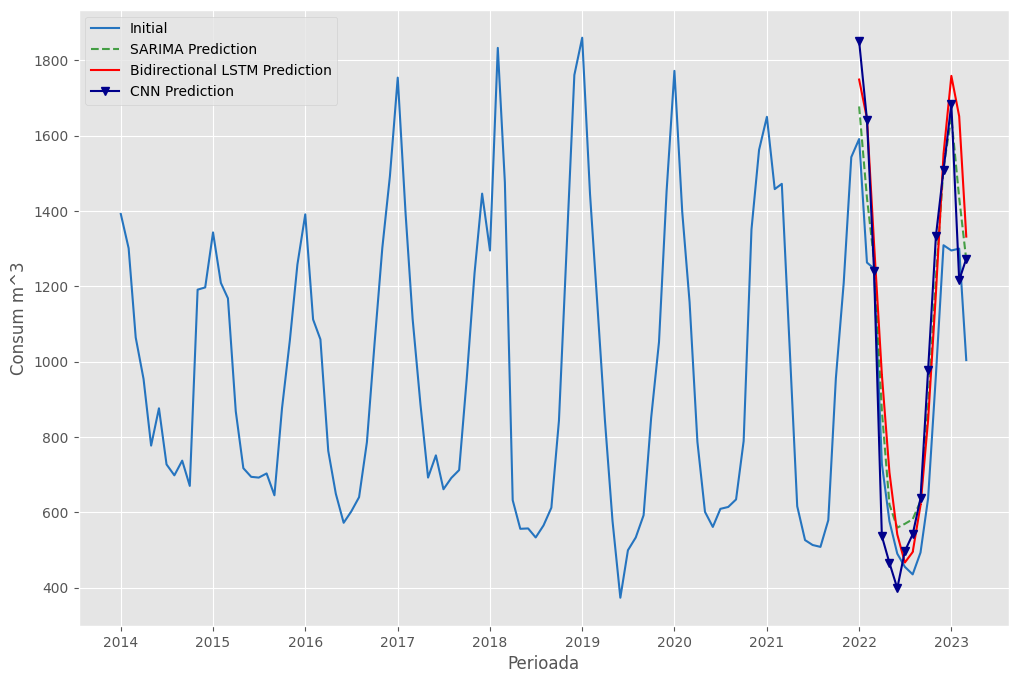

In [85]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Initial",color='#2574BF')

#SARIMA 12
plt.plot(sarima_predict_12.predicted_mean, label='SARIMA Prediction', alpha= 0.7,linestyle= "--", color='g')

#Bidirectional LSTM
plt.plot(df[96:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')

#CNN
plt.plot(df[96:].index,preds,label="CNN Prediction",marker='v',color='darkblue')

plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend(loc='upper left')
plt.show()

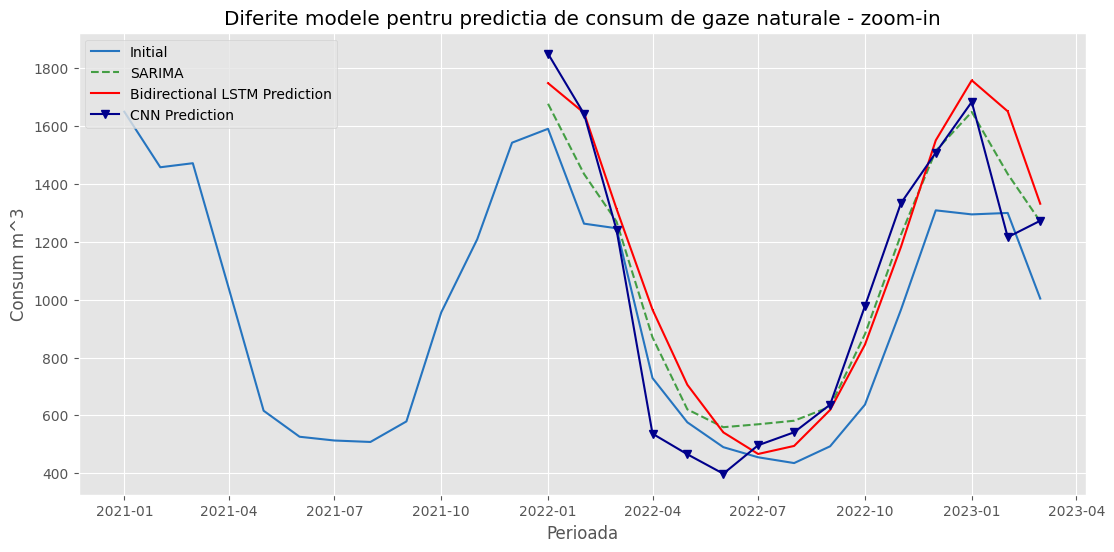

In [90]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df[84:].index, df[84:], color='#2574BF',label='Initial')
#SARIMA
plt.plot(sarima_predict_12.predicted_mean, label='SARIMA', alpha= 0.7,linestyle= "--", color='g')

#Bidirectional LSTM
plt.plot(df[96:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')

#CNN
plt.plot(df[96:].index,preds,label="CNN Prediction",marker='v',color='darkblue')

plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend()
plt.title('Diferite modele pentru predictia de consum de gaze naturale - zoom-in')
plt.show()